In [1]:
"""
Debug gclm2lenmap
"""
import numpy as np
import time
import healpy as hp
import matplotlib.pyplot as plt
import cunusht
import sys
from time import process_time

import cupy as cp
from delensalot.sims.sims_lib import Xunl, Xsky
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

runinfos = [
    # ("CPU", "lenspyx", 'ducc'),
    ("CPU", "duccnufft", 'ducc'),
    ("GPU", "cufinufft", 'shtns')
    ]

lmaxs = [1023]
epsilon = 1e-4
nthreads = 10
phi_lmaxs = [lmax for lmax in lmaxs]
defres = {}
Tsky = None
Tsky2 = None
truth = None
pixs = None
def nalm(lmax, mmax=None):
    mmax = lmax if mmax is None else mmax
    return int(((mmax+1)*(mmax+2))//2 + (mmax+1)*(lmax-mmax))

for lmax, phi_lmax in zip(lmaxs, phi_lmaxs):
    geominfo = ('gl',{'lmax':lmax})
    lenjob_geominfo = ('gl',{'lmax':phi_lmax})
    lldlm = np.arange(0,phi_lmax+1)
    synunl = Xunl(lmax=lmax, geominfo=geominfo, phi_lmax=phi_lmax)
    synsky = Xsky(lmax=lmax, unl_lib=synunl, geominfo=geominfo, lenjob_geominfo=lenjob_geominfo, epsilon=1e-10)
    philm = synunl.get_sim_phi(0, space='alm')
    toydlm = hp.almxfl(philm, np.sqrt(lldlm*(lldlm+1)))
    toyunllm = synunl.get_sim_unl(0, spin=0, space='alm', field='temperature')
    Tsky = synsky.get_sim_sky(0, spin=0, space='map', field='temperature')
    Tsky2 = synsky.unl2len(toyunllm, philm, spin=0)
    # nalm_unl = hp.Alm.getsize(lmax, mmax=lmax)
    # toyunllm = np.random.rand(nalm_unl)*1e-6 + 1j*np.random.rand(nalm_unl)*1e-6
    # toydlm = np.random.rand(nalm_unl)*1e-6 + 1j*np.random.rand(nalm_unl)*1e-6

    for runinfo in runinfos:
        backend = runinfo[0]
        defres.update({backend: {}}) if backend not in defres.keys() else None
        solver = runinfo[1]
        defres[backend].update({solver : None}) if solver not in defres[backend].keys() else None
        
        t = cunusht.get_transformer(solver, backend)
        if backend == 'CPU':
            if solver == 'lenspyx':
                kwargs = {
                    'geominfo_deflection': lenjob_geominfo,
                    'dglm': toydlm,
                    'mmax_dlm': lmax,
                    'nthreads': nthreads,
                    'verbosity': 1,
                    'epsilon': epsilon,
                    'single_prec': True,
                }   
                t = t(**kwargs)
                defres[backend][solver] = t.gclm2lenmap(
                        toyunllm.copy(), dlm=toydlm, lmax=lmax, mmax=lmax, spin=0, nthreads=10, execmode='debug', ptg=None)
            else:
                kwargs = {
                    'geominfo_deflection': lenjob_geominfo,
                    'nuFFTtype': None,
                }
                t = t(**kwargs)
                ptg = t.deflectionlib.dlm2pointing(toydlm, mmax_dlm=lmax, single_prec=False, nthreads=nthreads)
                pixs = np.arange(t.deflectionlib.geom.ofs[lmax//2], t.deflectionlib.geom.ofs[lmax//2]+3000).astype(int)
                truth = t.gclm2lenpixs(toyunllm.copy(), mmax=None, spin=0, pixs=pixs, ptg=ptg)
                defres[backend][solver] = t.gclm2lenmap(
                        gclm=toyunllm.copy(), dlm=toydlm, lmax=lmax, mmax=lmax, spin=0, nthreads=nthreads, epsilon=epsilon, execmode='debug', ptg=None)
                
        elif backend == 'GPU':
            kwargs = {
                'geominfo_deflection': lenjob_geominfo,
                'epsilon': epsilon,
                'nuFFTtype': 2,
            }   
            t = t(**kwargs)
            lenmap = cp.empty(t.deflectionlib.constructor.spat_shape, dtype=cp.complex128).flatten()
            ll = np.arange(0,lmax+1,1)
            dlm_scaled = hp.almxfl(toydlm, np.nan_to_num(np.sqrt(1/(ll*(ll+1)))))
            dlm_scaled = cp.array(np.atleast_2d(dlm_scaled), dtype=np.complex128) if kwargs['epsilon']<=1e-6 else cp.array(np.atleast_2d(dlm_scaled).astype(np.complex64))
            defres[backend][solver] = t.gclm2lenmap(cp.array(toyunllm.copy()), dlm_scaled=dlm_scaled, lmax=lmax, mmax=lmax, nthreads=nthreads, lenmap=lenmap, execmode='debug')

solverCPU, solverGPU = 'duccnufft', 'cufinufft'

[SHTns 3.6.6] built Apr  8 2024, 07:59:49, id: v3.6.6-10-g3986338*,avx512,ishioka,openmp,cuda
mpisupport: False, pmisupport: False
disabling mpi
Using lenspyx alm2map
INFO:: 05-08 15:54:36:: delensalot.sims.sims_lib.__init__ - sht_solver not given, defaulting to ducc
INFO:: 05-08 15:54:36:: delensalot.sims.sims_lib.__init__ - sht_backend not given, defaulting to CPU
INFO:: 05-08 15:54:36:: delensalot.sims.sims_lib.__init__ - sht_solver not given, defaulting to ducc
INFO:: 05-08 15:54:36:: delensalot.sims.sims_lib.__init__ - sht_backend not given, defaulting to CPU
CPU_SHT_DUCC_transformer.synthesis
  Input shapes:
    self: ()
    gclm: (524800,)
    spin: ()
    lmax: ()
    mmax: ()
    nthreads: ()
  Output shape: [(2097152,)], types: [<class 'numpy.ndarray'>]
CPU_SHT_DUCC_transformer.synthesis
  Input shapes:
    self: ()
    gclm: (524800,)
  Output shape: [(2097152,), (2097152,)], types: [<class 'numpy.ndarray'>, <class 'numpy.ndarray'>]
- - - - - - - - - - - - - - - Timing spin-

/tmp/ipykernel_2098222/625892259.py:93: RuntimeWarning: divide by zero encountered in divide
  dlm_scaled = hp.almxfl(toydlm, np.nan_to_num(np.sqrt(1/(ll*(ll+1)))))


- - - - - - - - - - - - - - - Timing synthesisgeneral: 0.127 seconds- - - - - - - - - - - - - - - 

::debug:: Returned component results
- - - - - - - - - - - - - - - Timing gclm2lenmap: 0.168 seconds- - - - - - - - - - - - - - - 



## Only for lenpsyx

In [2]:
defres['CPU']['lenspyx'].keys(), defres['GPU']['cufinufft'].keys()

KeyError: 'lenspyx'

In [ ]:
keyCPU = 'synthesisgeneral'
keyGPU = 'nuFFT2d2'
Tsky = Tsky2

vmin, vmax = -4e2, 4e2
resCPU = defres['CPU']['lenspyx'][keyCPU].real
resGPU = defres['GPU']['cufinufft'][keyGPU].real

fig, ax = plt.subplots(2,3, figsize=(16,6))

ax[0,0].imshow(Tsky.reshape(lmax+1,-1), vmin=vmin, vmax=vmax)
ax[0,0].set_title('Tsky')

ax[0,1].imshow(resCPU.reshape(lmax+1,-1), vmin=vmin, vmax=vmax)
ax[0,1].set_title('CPU')

im = ax[0,2].imshow(resGPU.reshape(lmax+1,-1), vmin=vmin, vmax=vmax)
ax[0,2].set_title('GPU')
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

vmin, vmax= -1e-16, 1e-16

im = ax[1,0].imshow(((resCPU-resGPU).reshape(lmax+1,-1)), vmin=vmin, vmax=vmax)
ax[1,0].set_title('CPU - GPU')
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,1].imshow(((Tsky-resCPU).reshape(lmax+1,-1)), vmin=vmin, vmax=vmax)
ax[1,1].set_title('Tsky - CPU')
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,2].imshow(((Tsky-resGPU).reshape(lmax+1,-1)), vmin=vmin, vmax=vmax)
divider = make_axes_locatable(ax[1,2])
ax[1,2].set_title('Tsky - GPU')
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

KeyError: 'nuFFT2d2'

(2, 2097152) (2097152, 2)


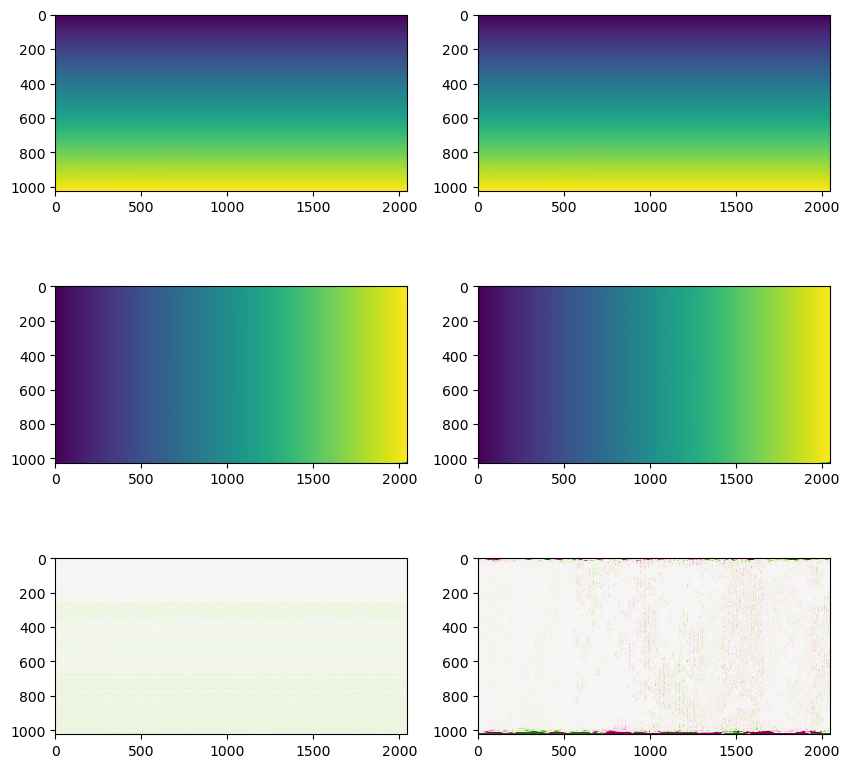

In [ ]:
keyGPU = 'dlm2pointing'
keyCPU = 'dlm2pointing'
solverCPU, solverGPU = 'lenspyx', 'cufinufft'

print(defres['GPU'][solverGPU][keyGPU].shape, defres['CPU'][solverCPU][keyCPU].shape)

fig, ax = plt.subplots(3,2, figsize=(10,10))

ax[0,0].imshow(defres['CPU'][solverCPU][keyCPU].T[0,:].reshape(lmax+1,-1))
ax[0,1].imshow(defres['GPU'][solverGPU][keyGPU].T[:,0].reshape(lmax+1,-1))

ax[1,0].imshow(defres['CPU'][solverCPU][keyCPU].T[1,:].reshape(lmax+1,-1))
ax[1,1].imshow(defres['GPU'][solverGPU][keyGPU].T[:,1].reshape(lmax+1,-1))

ax[2,0].imshow(defres['CPU'][solverCPU][keyCPU].T[0,:].reshape(lmax+1,-1) - defres['GPU'][solverGPU][keyGPU].T[:,0].reshape(lmax+1,-1), cmap='PiYG', vmin=-1e-15, vmax=1e-15)
ax[2,1].imshow(defres['CPU'][solverCPU][keyCPU].T[1,:].reshape(lmax+1,-1) - defres['GPU'][solverGPU][keyGPU].T[:,1].reshape(lmax+1,-1), cmap='PiYG', vmin=-1e-15, vmax=1e-15)

# all others

In [ ]:
solverCPU, solverGPU = 'duccnufft', 'cufinufft'
defres['CPU'][solverCPU].keys(), defres['GPU'][solverGPU].keys()

(dict_keys(['dlm2pointing', 'synthesis', 'doubling', 'C2C', 'nuFFT2d2', 'synthesisgeneral', 'rotate']),
 dict_keys(['dlm2pointing', 'synthesis', 'doubling', 'C2C', 'nuFFT2d2']))

### pointing things

(2, 2097152) (2, 2097152)


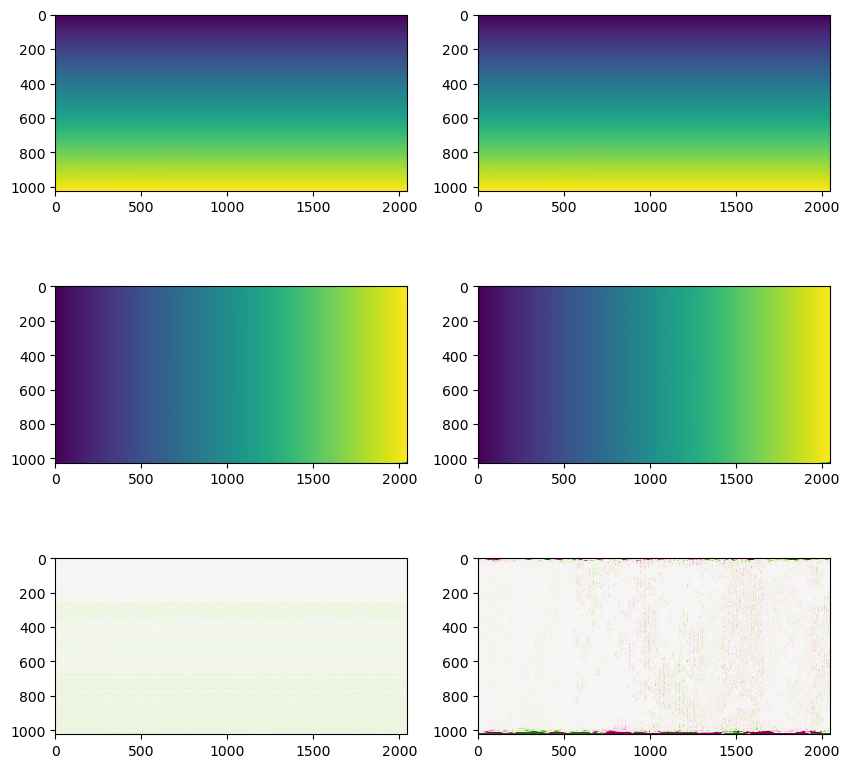

In [4]:
key = 'dlm2pointing'

print(defres['GPU'][solverGPU][key].shape, defres['CPU'][solverCPU][key].shape)
vmin, vmax = -1e-15, 1e-15
fig, ax = plt.subplots(3,2, figsize=(10,10))

ax[0,0].imshow(defres['CPU'][solverCPU][key][0,:].reshape(phi_lmax+1,-1))
ax[0,1].imshow(defres['GPU'][solverGPU][key].T[:,0].reshape(phi_lmax+1,-1))

ax[1,0].imshow(defres['CPU'][solverCPU][key][1,:].reshape(phi_lmax+1,-1))
ax[1,1].imshow(defres['GPU'][solverGPU][key].T[:,1].reshape(phi_lmax+1,-1))

ax[2,0].imshow(defres['CPU'][solverCPU][key][0,:].reshape(phi_lmax+1,-1) - defres['GPU'][solverGPU][key].T[:,0].reshape(phi_lmax+1,-1), cmap='PiYG', vmin=vmin, vmax=vmax)
ax[2,1].imshow(defres['CPU'][solverCPU][key][1,:].reshape(phi_lmax+1,-1) - defres['GPU'][solverGPU][key].T[:,1].reshape(phi_lmax+1,-1), cmap='PiYG', vmin=vmin, vmax=vmax)

## synthesis general

(1032, 2048) (1032, 2048)


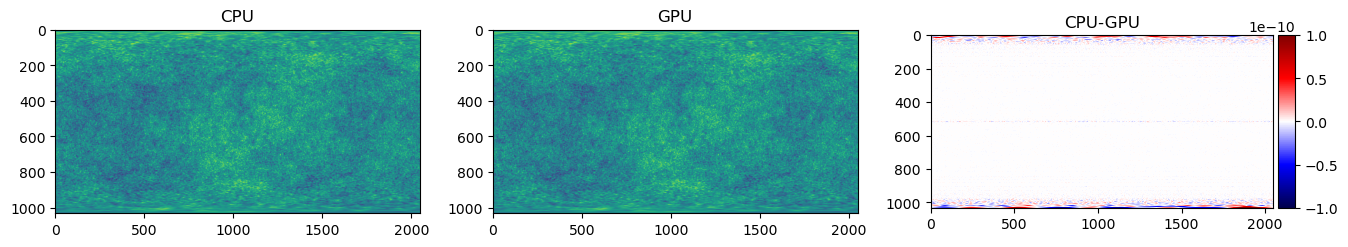

In [3]:
key = 'synthesis'
vmin=-1e-10
vmax=1e-10
fig, ax = plt.subplots(1,3, figsize=(16,4))

resCPU = defres['CPU'][solverCPU][key][0]
resGPU = defres['GPU'][solverGPU][key].reshape(t.constructor.nphi,-1).T
print(resCPU.shape, resGPU.shape)

ax[0].imshow(resCPU)
ax[0].set_title('CPU')

ax[1].imshow(resGPU)
ax[1].set_title('GPU')

im = ax[2].imshow(resCPU-resGPU, cmap='seismic', vmin=vmin, vmax=vmax)
ax[2].set_title('CPU-GPU')
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


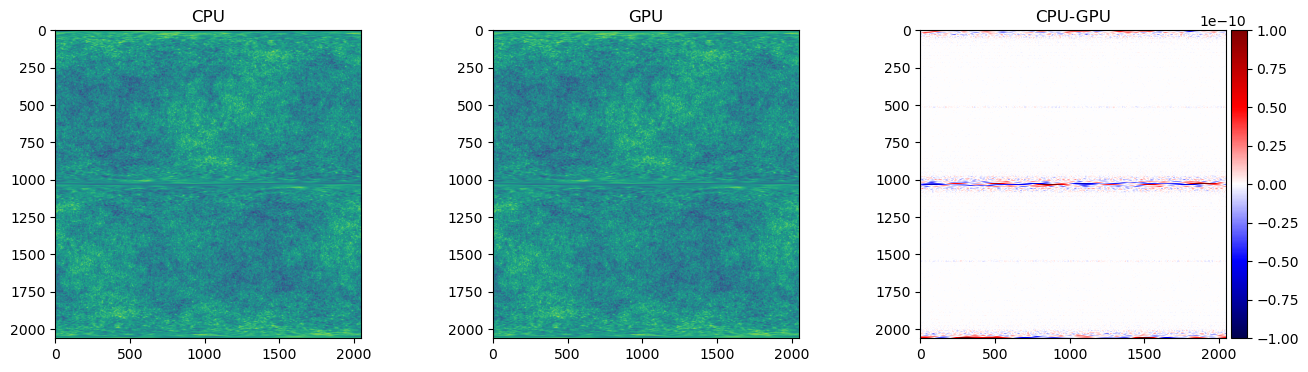

In [4]:
key = 'doubling'
vmin, vmax = -1e-10, 1e-10
fig, ax = plt.subplots(1,3, figsize=(16,4))
resCPU = defres['CPU'][solverCPU][key]
resGPU = defres['GPU'][solverGPU][key].reshape(t.constructor.nphi,-1).T

ax[0].imshow(resCPU)
ax[0].set_title('CPU')

ax[1].imshow(resGPU)
ax[1].set_title('GPU')

im = ax[2].imshow(resCPU-resGPU, cmap='seismic', vmin=vmin, vmax=vmax)
ax[2].set_title('CPU-GPU')
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


(2048, 2062) (2062, 2048)


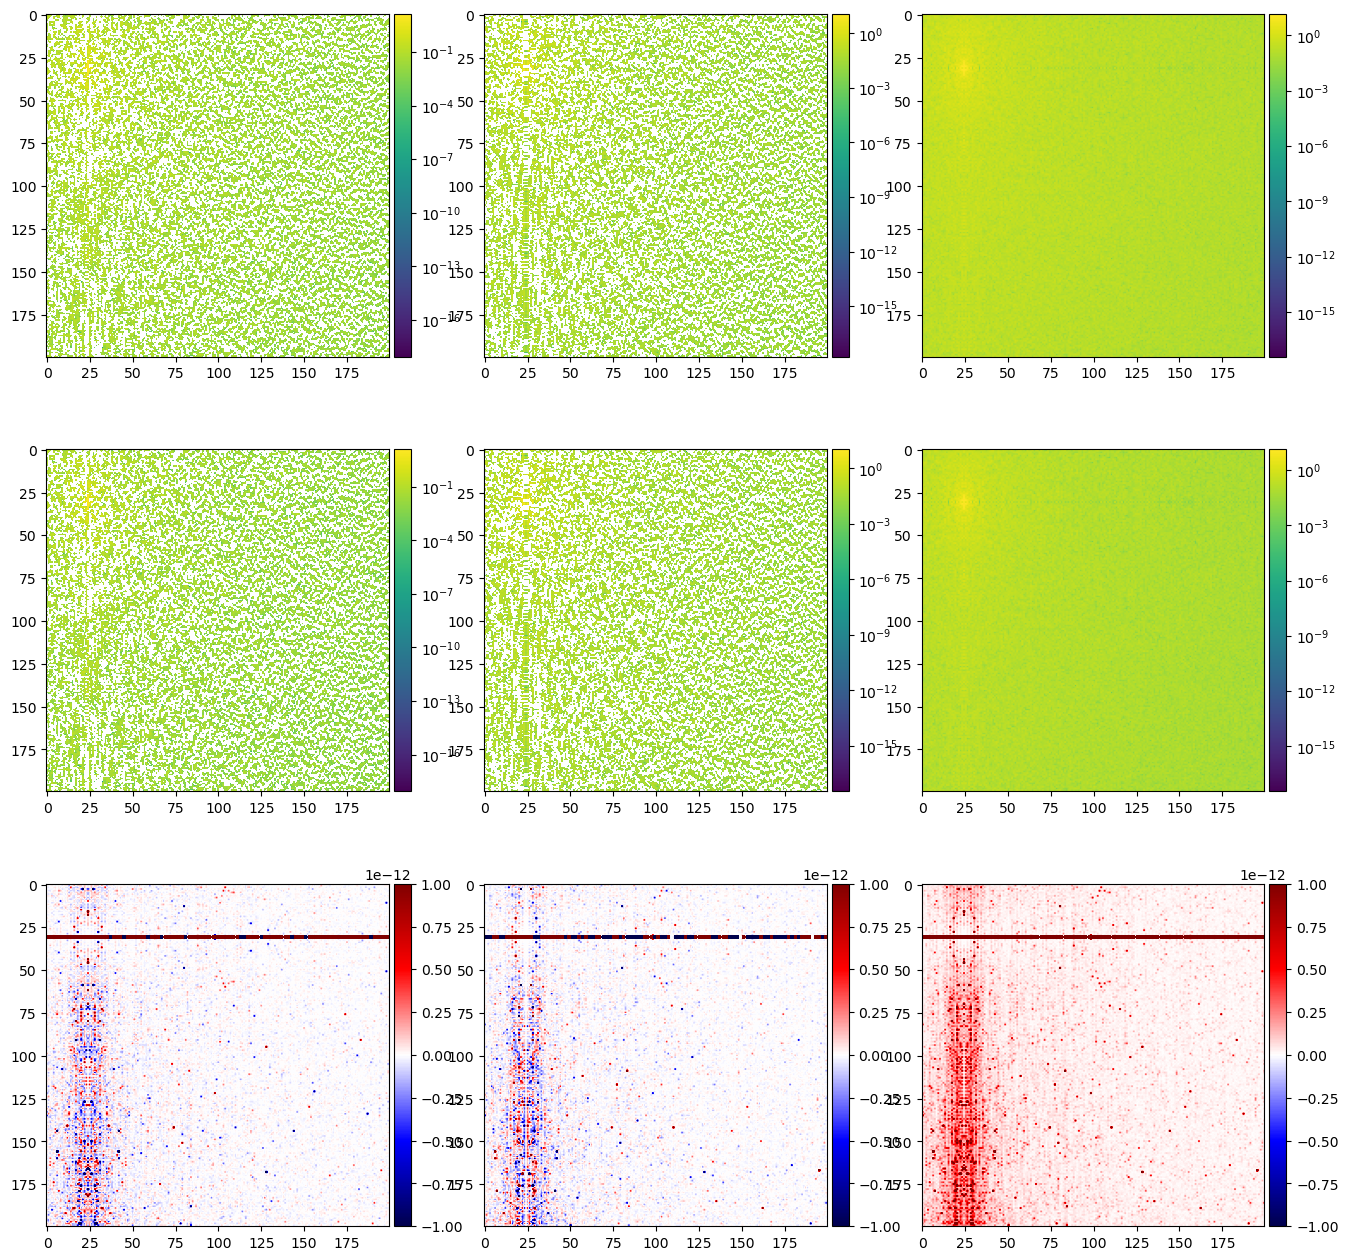

In [5]:
key = 'C2C'
solverCPU, solverGPU = 'duccnufft', 'cufinufft'
# print(defres['GPU'][solverGPU][key].shape, defres['CPU'][solverCPU][key].shape)
print(defres['GPU'][solverGPU][key].shape, defres['CPU'][solverCPU][key].shape)

fig, ax = plt.subplots(3,3, figsize=(16,16))

resCPU = np.fft.fftshift(defres['CPU'][solverCPU][key],axes=(0,1))[1000:1200,1000:1200]
resGPU = np.fft.fftshift(defres['GPU'][solverGPU][key].reshape(2*(lmax+1),-1).T,axes=(0,1))[1000:1200,1000:1200]

im = ax[0,0].imshow(np.real(resCPU), norm='log')
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
im = ax[0,1].imshow(np.imag(resCPU), norm='log')
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
im = ax[0,2].imshow(np.abs(resCPU), norm='log')
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


im = ax[1,0].imshow(np.real(resGPU), norm='log')
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,1].imshow(np.imag(resGPU), norm='log')
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,2].imshow(np.abs(resGPU), norm='log')
divider = make_axes_locatable(ax[1,2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


vmin, vmax = -1e-12, 1e-12
# vmin, vmax = None, None
im = ax[2,0].imshow(np.real((resCPU - resGPU)/resCPU), vmin=vmin, vmax=vmax, cmap='seismic')
divider = make_axes_locatable(ax[2,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[2,1].imshow(np.imag((resCPU - resGPU)/resCPU), vmin=vmin, vmax=vmax, cmap='seismic')
divider = make_axes_locatable(ax[2,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[2,2].imshow(np.abs((resCPU - resGPU)/resCPU), vmin=vmin, vmax=vmax, cmap='seismic')
divider = make_axes_locatable(ax[2,2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

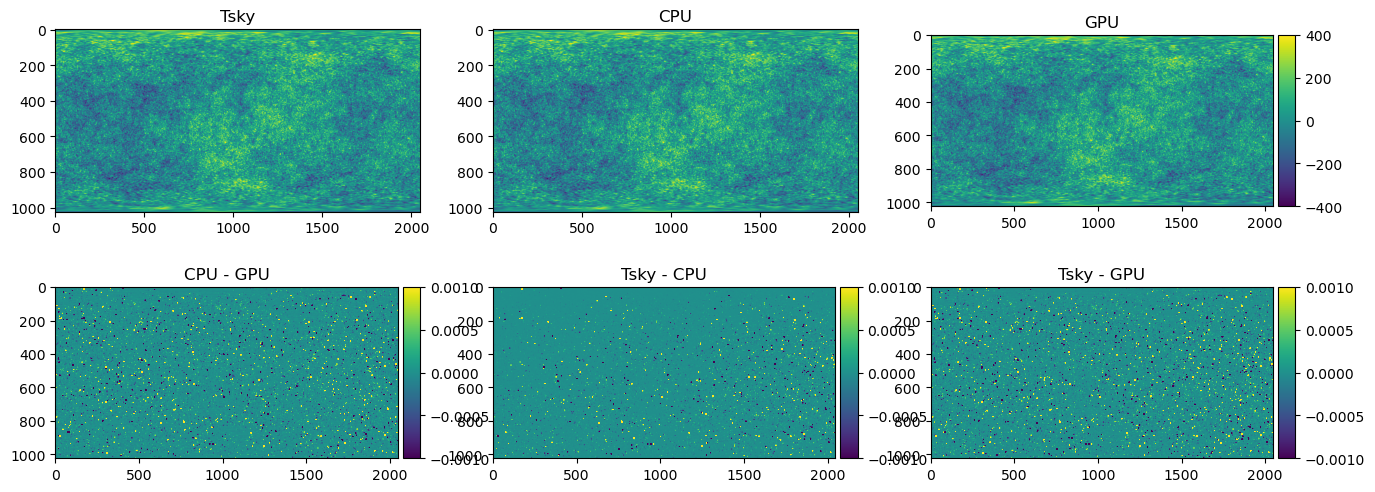

In [3]:
key = 'nuFFT2d2'
Tsky = Tsky2
resCPU = defres['CPU'][solverCPU][key].real
vmin, vmax = -4e2, 4e2
resCPU = defres['CPU'][solverCPU][key].real
resGPU = defres['GPU'][solverGPU][key].real

fig, ax = plt.subplots(2,3, figsize=(16,6))

ax[0,0].imshow(Tsky.reshape(lmax+1,-1).real, vmin=vmin, vmax=vmax)
ax[0,0].set_title('Tsky')

ax[0,1].imshow(resCPU.reshape(phi_lmax+1,-1), vmin=vmin, vmax=vmax)
ax[0,1].set_title('CPU')

im = ax[0,2].imshow(resGPU.reshape(lmax+1,-1), vmin=vmin, vmax=vmax)
ax[0,2].set_title('GPU')
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


vmin, vmax = -1e-3, 1e-3
im = ax[1,0].imshow(((resCPU-resGPU)/resCPU).reshape(lmax+1,-1), vmin=vmin, vmax=vmax)
ax[1,0].set_title('CPU - GPU')
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,1].imshow((((Tsky-resCPU)/Tsky).reshape(lmax+1,-1)), vmin=vmin, vmax=vmax)
ax[1,1].set_title('Tsky - CPU')
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,2].imshow((((Tsky-resGPU)/Tsky).reshape(lmax+1,-1)), vmin=vmin, vmax=vmax)
divider = make_axes_locatable(ax[1,2])
ax[1,2].set_title('Tsky - GPU')
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

In [4]:
np.mean((truth-resGPU[pixs])/truth), np.mean((truth-resCPU[pixs])/truth)

(0.00041667615263609413, 6.425721202822437e-05)

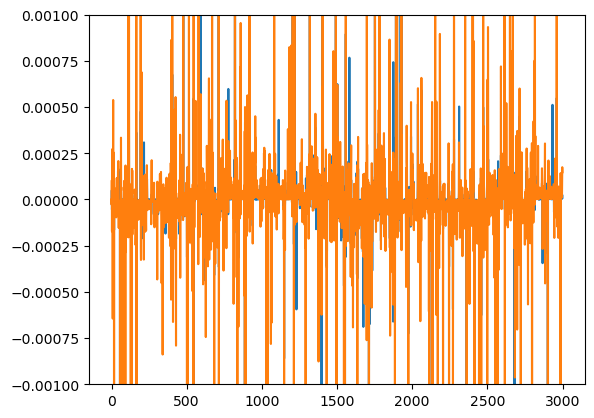

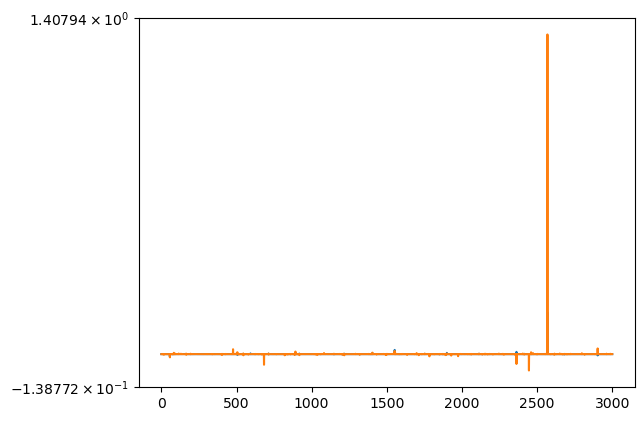

In [13]:
# plt.plot(truth)
plt.plot(np.abs(truth-resCPU[pixs])/truth)
plt.plot(np.abs(truth-resGPU[pixs])/truth)
plt.ylim(-1e-3,1e-3)
# plt.yscale('log')
plt.show()

plt.plot((truth-resCPU[pixs])/truth)
plt.plot((truth-resGPU[pixs])/truth)
plt.yscale('symlog')
plt.show()

CPU_SHT_DUCC_transformer.synthesis
  Input shapes:
    self: ()
    gclm: (524800,)
    spin: ()
    lmax: ()
    mmax: ()
    nthreads: ()
  Output shape: [(2097152,)], types: [<class 'numpy.ndarray'>]


"differences to Tsky could be due to ntheta and nphi in _synthCARgrid() which are currently not 'good size'\n"

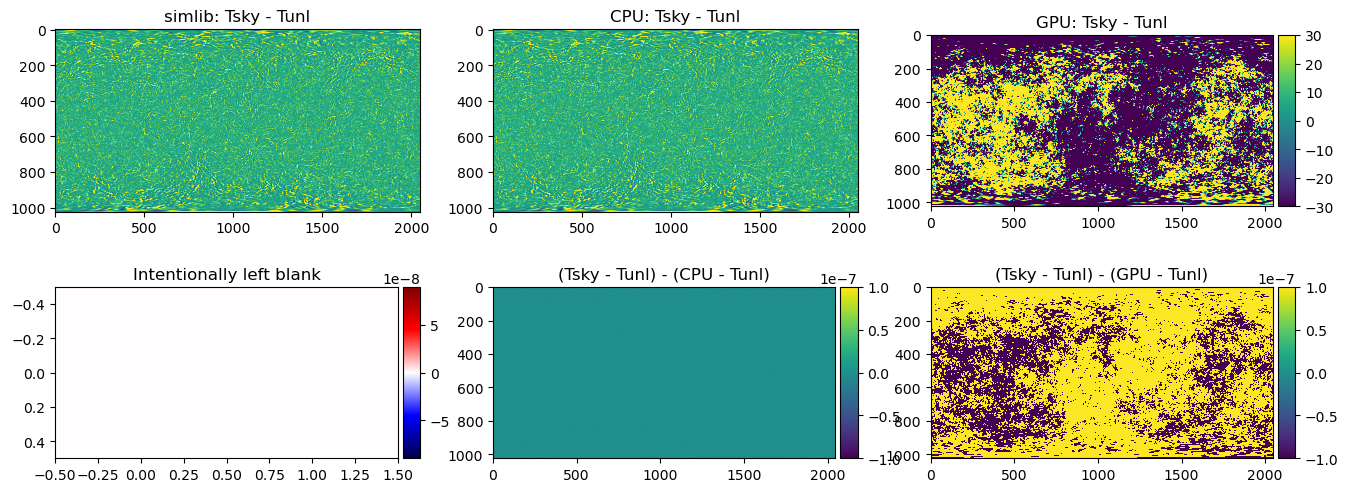

In [7]:
key = 'nuFFT2d2'
# print(defres['GPU'][solverGPU][key].shape, defres['CPU'][solverCPU][key].shape)
Tsky = Tsky2
Tunlmap = synunl.get_sim_unl(0, spin=0, space='map', field='temperature')
resCPU = defres['CPU'][solverCPU][key].real
vmin, vmax = -3e1, 3e1
resCPU = defres['CPU'][solverCPU][key].real
resGPU = defres['GPU'][solverGPU][key][0].real

fig, ax = plt.subplots(2,3, figsize=(16,6))

ax[0,0].imshow((Tsky-Tunlmap).reshape(lmax+1,-1).real, vmin=vmin, vmax=vmax)
ax[0,0].set_title('simlib: Tsky - Tunl')

ax[0,1].imshow((resCPU-Tunlmap).reshape(lmax+1,-1), vmin=vmin, vmax=vmax)
ax[0,1].set_title('CPU: Tsky - Tunl')

im = ax[0,2].imshow((resGPU-Tunlmap).reshape(lmax+1,-1), vmin=vmin, vmax=vmax)
ax[0,2].set_title('GPU: Tsky - Tunl')
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


im = ax[1,0].imshow([[0,0]], vmin=-9e-8, vmax=9e-8, cmap='seismic')
ax[1,0].set_title('Intentionally left blank')
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,1].imshow(((Tsky-Tunlmap)-(resCPU-Tunlmap)).reshape(lmax+1,-1), vmin=-1e-7, vmax=1e-7)
ax[1,1].set_title('(Tsky - Tunl) - (CPU - Tunl)')
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,2].imshow(((Tsky-Tunlmap)-(resGPU-Tunlmap)).reshape(lmax+1,-1), vmin=-1e-7, vmax=1e-7)
divider = make_axes_locatable(ax[1,2])
ax[1,2].set_title('(Tsky - Tunl) - (GPU - Tunl)')
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


"""differences to Tsky could be due to ntheta and nphi in _synthCARgrid() which are currently not 'good size'
"""